In [1]:
import sys
import json
import copy
import logging
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ, QuantumCircuit, QuantumRegister, transpile
from qiskit.ignis.mitigation.measurement import complete_meas_cal, MeasurementFilter
from qiskit.providers.ibmq.runtime.utils import RuntimeEncoder, RuntimeDecoder
#from qiskit.providers.ibmq.runtime import UserMessenger

#logging.basicConfig(level=logging.WARNING, format='%(asctime)s: %(message)s')
#logging.getLogger('schwinger_rqd').setLevel(logging.INFO)

sys.path.append('..')
from main import make_step_circuits, run_forward_circuits, rqd_step, main
from pnp_ansatze import make_pnp_ansatz
from observables import plot_counts_with_curve
from trotter import trotter_step_circuits

## Runtime job input

In [2]:
inputs = {
    'num_sites': 4,
    'aJ': 1.,
    'am': 0.5,
    'omegadt': 0.2,
    'num_tsteps': 4,
    'tsteps_per_rqd': 2,
    'error_matrix': np.eye(16, dtype='f8'),
    'physical_qubits': None,
    'minimizer_shots_per_job': 1000,
    'minimizer_jobs': 2,
    'forward_shots': 2 * 8192,
    'max_sweeps': 100
}

logging.getLogger('four_qubit_schwinger').setLevel(logging.INFO)

## Testing just the forward steps

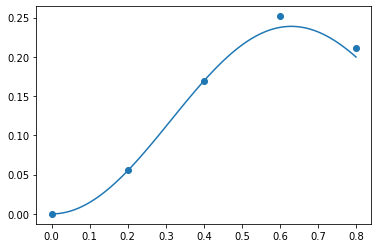

In [3]:
backend = Aer.get_backend('statevector_simulator')

num_sites = inputs['num_sites']
aJ = inputs['aJ']
am = inputs['am']
omegadt = inputs['omegadt']
num_tsteps = inputs['num_tsteps']
physical_qubits = inputs['physical_qubits']
error_matrix = inputs['error_matrix']
forward_shots = inputs['forward_shots']

_, state_labels = complete_meas_cal(qubit_list=list(range(num_sites)), qr=QuantumRegister(num_sites), circlabel='mcal')
error_mitigation_filter = MeasurementFilter(error_matrix, state_labels)

forward_circuits = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)

target_circuits = trotter_step_circuits(num_tsteps, forward_circuits, initial_state=None, measure=False)

counts_list = run_forward_circuits(target_circuits, backend, initial_layout=physical_qubits, shots=forward_shots, error_mitigation_filter=error_mitigation_filter)

plot_counts_with_curve(counts_list, num_sites, aJ, am, omegadt, num_tsteps, initial_state=None, num_toys=0)

## A UserMessenger class that saves all published results

In [4]:
class UserMessenger:
    """Base class for handling communication with program users.

    This class can be used when writing a new Qiskit Runtime program.
    """
    
    def __init__(self):
        self.results = []

    def publish(
            self,
            message,
            encoder=None,
            final=False
    ) -> None:
        self.results.append(message)

## Testing one RQD step

In [5]:
backend = Aer.get_backend('qasm_simulator')

num_sites = inputs['num_sites']
aJ = inputs['aJ']
am = inputs['am']
omegadt = inputs['omegadt']
tsteps_per_rqd = inputs['tsteps_per_rqd']
physical_qubits = inputs['physical_qubits']
error_matrix = inputs['error_matrix']

_, state_labels = complete_meas_cal(qubit_list=list(range(num_sites)), qr=QuantumRegister(num_sites), circlabel='mcal')
error_mitigation_filter = MeasurementFilter(error_matrix, state_labels)

forward_step_circuits = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)
    
if num_sites == 2:
    approximator = make_pnp_ansatz(
        num_qubits=num_sites,
        num_layers=num_sites // 2,
        initial_x_positions=[0])
elif num_sites == 4:
    approximator = make_pnp_ansatz(
        num_qubits=num_sites,
        num_layers=num_sites // 2,
        initial_x_positions=[1, 2],
        structure=[(1, 2), (0, 1), (2, 3)],
        first_layer_structure=[(0, 1), (2, 3)])
    
user_messenger = UserMessenger()

optimal_params = rqd_step(
    0,
    inputs,
    backend,
    forward_step_circuits,
    approximator,
    error_mitigation_filter=error_mitigation_filter,
    user_messenger=user_messenger
)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


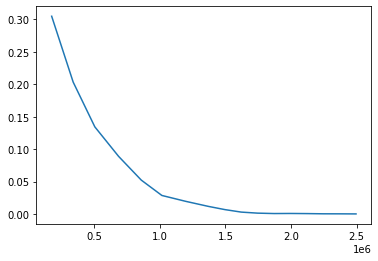

In [6]:
plt.plot(user_messenger.results[-1]['shots_values'], user_messenger.results[-1]['cost_values'])

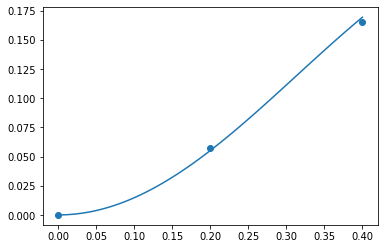

In [7]:
plot_counts_with_curve(user_messenger.results[0]['forward_counts'], num_sites, aJ, am, omegadt, tsteps_per_rqd, initial_state=None, num_toys=0)

In [8]:
user_messenger_2 = UserMessenger()

optimal_params = rqd_step(
    1,
    inputs,
    backend,
    forward_step_circuits,
    approximator,
    optimal_params=optimal_params,
    error_mitigation_filter=error_mitigation_filter,
    user_messenger=user_messenger_2
)

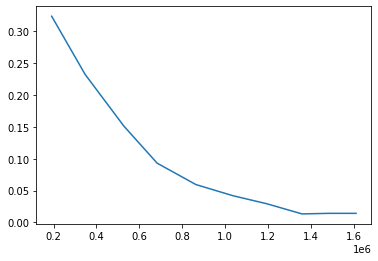

In [9]:
plt.plot(user_messenger_2.results[-1]['shots_values'], user_messenger_2.results[-1]['cost_values'])

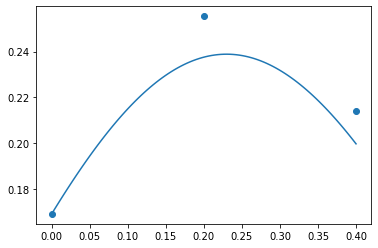

In [10]:
from hamiltonian import schwinger_model, diagonalized_evolution

vacuum_state = np.zeros(2 ** num_sites, dtype=np.complex128)
vacuum_state_index = 0
for j in range(0, num_sites, 2):
    vacuum_state_index += (1 << j)
vacuum_state[vacuum_state_index] = 1.

hamiltonian = schwinger_model(num_sites, aJ, am)
_, statevectors = diagonalized_evolution(hamiltonian, vacuum_state, omegadt * tsteps_per_rqd)

plot_counts_with_curve(user_messenger_2.results[0]['forward_counts'], num_sites, aJ, am, omegadt, tsteps_per_rqd, initial_state=statevectors[:, -1], num_toys=0)

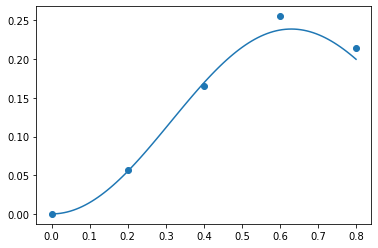

In [11]:
plot_counts_with_curve(user_messenger.results[0]['forward_counts'] + user_messenger_2.results[0]['forward_counts'], num_sites, aJ, am, omegadt, tsteps_per_rqd * 2, initial_state=None, num_toys=0)

## Testing the main function

In [12]:
class UserMessengerForwardOnly:
    """Base class for handling communication with program users.

    This class can be used when writing a new Qiskit Runtime program.
    """
    
    def __init__(self):
        self.results = []

    def publish(
            self,
            message,
            encoder=None,
            final=False
    ) -> None:
        if 'forward_counts' not in message:
            return
        
        self.results.append(message)

In [13]:
backend = Aer.get_backend('qasm_simulator')

serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

user_messenger_fw = UserMessengerForwardOnly()

main(backend, user_messenger_fw, **deserialized_inputs)

'All done!'

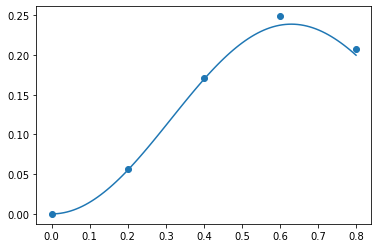

In [14]:
forward_counts = []
for res in user_messenger_fw.results:
    forward_counts += res['forward_counts']
    
plot_counts_with_curve(forward_counts, inputs['num_sites'], inputs['aJ'], inputs['am'], inputs['omegadt'], inputs['num_tsteps'], initial_state=None, num_toys=0)

In [15]:
interim_result = user_messenger.results[-3]
print(interim_result)

{'rqd_step': 0, 'state': {'_encoded': ['param_val', 'initial_param_val'], 'param_val': ('4017824540743d6b', '3fe001f9336436e4', '3ff8fe6cd45d6bb6', '3fd7a0721e2c7cb8', '3ff3a0035d3aeb0e', '4002da2c977adfeb', '3fe921fb54442d18', '3fe921fb54442d18', '3ff2ed58ed978ce7', '3ff0fe1f81ba88d8'), 'sweep': 16, 'cost': 0.00018281870170233053, 'shots': 2495000, 'strategy': 'largest-drop', 'raw_data': {'4005e28f2ca44dbe3fe001f9336436e43ff8fe6cd45d6bb63fd7a0721e2c7cb83ff3a0035d3aeb0e4002da2c977adfeb3fe921fb54442d183fe921fb54442d183ff2ed58ed978ce73ff0fe1f81ba88d8': {'1111': 1, '0000': 999}, '400a12e3baafaa983fe001f9336436e43ff8fe6cd45d6bb63fd7a0721e2c7cb83ff3a0035d3aeb0e4002da2c977adfeb3fe921fb54442d183fe921fb54442d183ff2ed58ed978ce73ff0fe1f81ba88d8': {'0011': 249, '0000': 751}, '400e433848bb07713fe001f9336436e43ff8fe6cd45d6bb63fd7a0721e2c7cb83ff3a0035d3aeb0e4002da2c977adfeb3fe921fb54442d183fe921fb54442d183ff2ed58ed978ce73ff0fe1f81ba88d8': {'1100': 1, '0011': 738, '0000': 261}, '401139c66b6332253fe00

In [16]:
inputs['resume_from'] = {
    'rqd_step': interim_result['rqd_step'],
    'state': interim_result['state'],
    'minimizer_state': interim_result['minimizer_state']
}

serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

user_messenger_fw_2 = UserMessengerForwardOnly()

main(backend, user_messenger_fw_2, **deserialized_inputs)

'All done!'

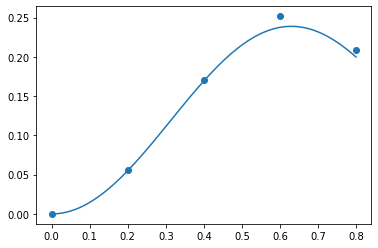

In [17]:
forward_counts = copy.deepcopy(user_messenger_fw.results[0]['forward_counts'])
for res in user_messenger_fw_2.results:
    forward_counts += res['forward_counts']

plot_counts_with_curve(forward_counts, inputs['num_sites'], inputs['aJ'], inputs['am'], inputs['omegadt'], inputs['num_tsteps'], initial_state=None, num_toys=0)